In [1]:
import sys
sys.path.append("../")
import utils
v_data, e_data, core_targets, ext_targets, core_testing = utils.load_for_jupyter_raw()

Dataset already downloaded. Loading it from file system
LOADING DATA: 0.99 s


# Node degree

Node degree is simply the number of edges incident to a node.

for each node ID, sift through the edges and look for that node as both source and destination.

The loop for the entire graph iterates 270 billion times.

Clearly there is a better way. The firs that came to my mind is to use Pandas `groupby()` function to count how many times each value appears in the from_id and to_id columns, which is much more easy computationally.

Then I can create a dataframe from the data I just created. This way, I can use the `merge()` function to add the row corresponding to the node ID.

This way I can easily compute the degree for both source and target edges, which might be more insightful than just the total degree (which is the sum)

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns

In [35]:
e_data

,from_id,to_id,Label,Similarity Strength,Amount Flag
edge_id,,,,,
400111489790,1502000,2003003713,money transfer,NaN,medium
400111390345,1502000,20030012850,money transfer,NaN,small
350111213741,1502001,15020066888,money transfer,NaN,small
350111280215,1502001,15020063877,money transfer,NaN,medium
400111415408,1502001,20030019012,money transfer,NaN,small
...,...,...,...,...,...
650111831593,20030017545,3001182900,is similar,weak,NaN
650111820399,20030017545,3001184369,is similar,medium,NaN
650111814941,20030017545,3001147740,is similar,medium,NaN


In [50]:
e_data.groupby('from_id').count().to_id
# this means that there are 5 edges going from node id 100100 to other IDs.

from_id
100100          5
100101          5
100102          7
100103          6
100104          9
               ..
20030025114     9
20030025115     9
20030025116    10
20030025117     9
20030025118     3
Name: to_id, Length: 170950, dtype: int64

In [73]:
source_data = e_data.groupby('from_id').count().to_id
source_data = pd.DataFrame(source_data)
source_data = source_data.rename(columns={'to_id': 'source_degree'})
source_data = source_data.rename_axis('node_id')

In [74]:
source_data

,source_degree
node_id,
100100,5
100101,5
100102,7
100103,6
100104,9
...,...
20030025114,9
20030025115,9
20030025116,10


In [75]:
target_data = e_data.groupby('to_id').count().from_id
target_data = pd.DataFrame(target_data)
target_data = target_data.rename(columns={'from_id': 'target_degree'})
target_data = target_data.rename_axis('node_id')

In [76]:
target_data

,target_degree
node_id,
250110,1
250112,2
250113,1
250114,2
250115,1
...,...
20030025114,2
20030025115,2
20030025116,2


In [80]:
w_deg = pd.merge(v_data, source_data, left_index=True, right_index=True, how='left')
w_deg = pd.merge(w_deg, target_data, left_index=True, right_index=True, how='left')

In [82]:
w_deg['source_degree'].value_counts()

5.0     27930
4.0     27678
6.0     23738
3.0     22307
7.0     17793
2.0     13714
8.0     12180
9.0      8131
1.0      5527
10.0     5089
11.0     3121
12.0     1727
13.0     1009
14.0      514
15.0      265
16.0      122
17.0       63
18.0       24
19.0       12
20.0        3
21.0        2
22.0        1
Name: source_degree, dtype: int64

In [108]:
w_deg['target_degree'].value_counts()

1.0     81722
2.0     28198
3.0     22494
4.0     19167
5.0     18603
6.0     18040
7.0     16058
8.0     13000
9.0      9113
10.0     5972
11.0     3399
12.0     1838
13.0      870
14.0      375
15.0      164
16.0       70
17.0       24
18.0       11
19.0        1
Name: target_degree, dtype: int64

In [84]:
w_deg['source_degree'].isna().sum()

148426

In [86]:
w_deg['target_degree'].isna().sum()

80257

# Observations

It appears that the nodes are quite balanced in terms of degree.

It may be a good improvement to plot the value_counts and maybe fit a transform to normalize them.

In [134]:
sd = pd.DataFrame(w_deg['source_degree'].value_counts())
sd = dp.rename_axis('frequency')
td = pd.DataFrame(w_deg['target_degree'].value_counts())
td = td.rename_axis('frequency')

<AxesSubplot:xlabel='frequency'>

<Figure size 576x288 with 0 Axes>

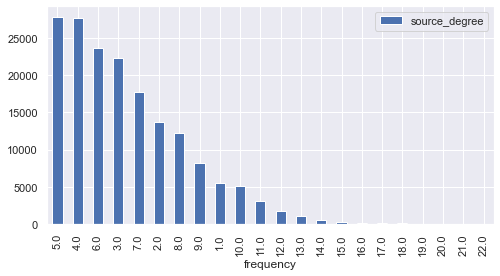

In [135]:
plt.figure()
sd.plot(kind='bar')

<AxesSubplot:xlabel='frequency'>

<Figure size 576x288 with 0 Axes>

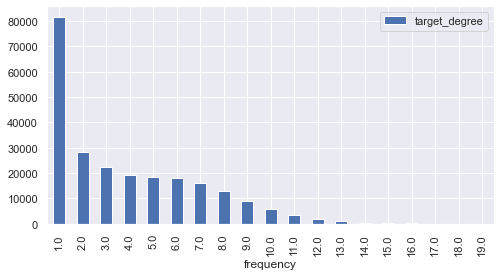

In [136]:
plt.figure()
td.plot(kind='bar')

Looks like the target degree is more imbalanced.